# Advanced Stimulus Options

## Example: Advanced IClamp Options

By default you can insert a simple step current into your simulation by adding to the "inputs" section of your SONATA configuration file. For example, say we want to insert a .100 nA injection at for 1000 ms into the soma of our first cell:

```json
"inputs": {
    "current_clamp": {
        "input_type": "clamp",
        "module": "IClamp",
        "node_set": {
            "population": "net"
            "node_id": 0
        },
        "amp": 0.1000,
        "delay": 500.0,
        "duration": 1000.0,
        "section_name": "soma",
        "section_index": 0,
        "section_dist": 0.5
    }
}
```
* **input_typ** and **module** should always be set to values `clamp` and `IClamp`, respecitvely.
* The **node_set** specifies what cell(s) we want to apply clamp to. In this case only cell with node-id #0 in the "net" population of cells.
* **amp** is the amplitude of the clamp to apply, in nA.
* **delay** and **duration** tells us when to start the clamp and how long to apply it for, both in ms. In this case it will be a current from 500 - 1500 ms after start of simulation.
* **section_name**, **section_index**, and **section_dist** tells us exactly where on the cell to place the clamp. In this case at the center of the soma. (*If you leave section_index and section_dist blank BMTK will attempt to find a random avaialble place where to insert the clamp*)
<div class="alert alert-block alert-info">
 NOTE: For PoinNet users section_name, section_index and section_dist is not applicable and can be removed.
</div>


In [5]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.current_clamp.json')
conf.build_env()

graph = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=graph)
sim.run()

2024-05-05 10:30:21,328 [INFO] Created log file
2024-05-05 10:30:21,425 [INFO] Building cells.
2024-05-05 10:30:22,432 [INFO] Building recurrent connections
2024-05-05 10:30:22,441 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2024-05-05 10:30:22,442 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-05-05 10:30:22,443 [INFO] Block save every 5000 steps
2024-05-05 10:30:23,460 [INFO]     step:5000 t_sim:500.00 ms
2024-05-05 10:30:24,561 [INFO]     step:10000 t_sim:1000.00 ms
2024-05-05 10:30:25,690 [INFO]     step:15000 t_sim:1500.00 ms
2024-05-05 10:30:26,812 [INFO]     step:20000 t_sim:2000.00 ms
2024-05-05 10:30:26,836 [INFO] Simulation completed in 4.394 seconds 


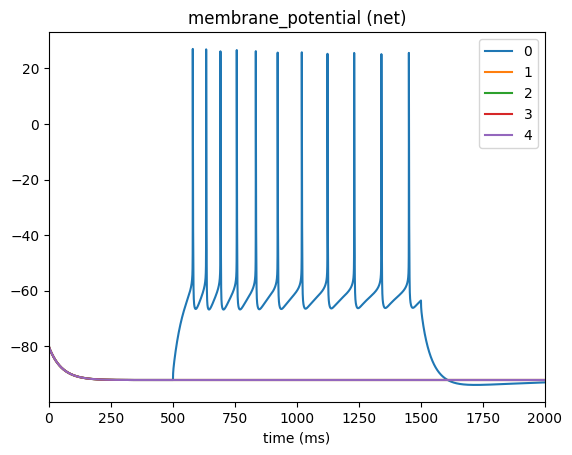

In [9]:
from bmtk.analyzer.compartment import plot_traces
_ = plot_traces(config_file='config.current_clamp.json',  node_ids=range(5), report_name='membrane_potential')

#### Selecting multiple cells

In the above cells #1-4 have a flat trace since we only applied the current to cell #0. If you want to apply the same current to a specific population of cells you can use the **node_set** option to filter according to any available attributes. For example, say we want to apply the current cells in our network that have **model_type=biophysical**:

```json
"current_clamp": {
    "input_type": "current_clamp",
    "module": "IClamp",
    "node_set": {
        "population": "net", 
        "model_type": "biophysical"
    },
    "amp": 0.1000,
    "delay": 500.0,
    "duration": 1000.0,
    "section_name": "soma"
}
```

In [10]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.current_clamp_allcells.json')
conf.build_env()

graph = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=graph)
sim.run()

2024-05-05 10:38:22,112 [INFO] Created log file
Mechanisms already loaded from path: ./components/mechanisms.  Aborting.
2024-05-05 10:38:22,130 [INFO] Building cells.
2024-05-05 10:38:23,128 [INFO] Building recurrent connections
2024-05-05 10:38:23,141 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2024-05-05 10:38:23,142 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-05-05 10:38:23,143 [INFO] Block save every 5000 steps
2024-05-05 10:38:24,566 [INFO]     step:5000 t_sim:500.00 ms
2024-05-05 10:38:25,905 [INFO]     step:10000 t_sim:1000.00 ms
2024-05-05 10:38:27,381 [INFO]     step:15000 t_sim:1500.00 ms
2024-05-05 10:38:28,682 [INFO]     step:20000 t_sim:2000.00 ms
2024-05-05 10:38:28,700 [INFO] Simulation completed in 5.559 seconds 


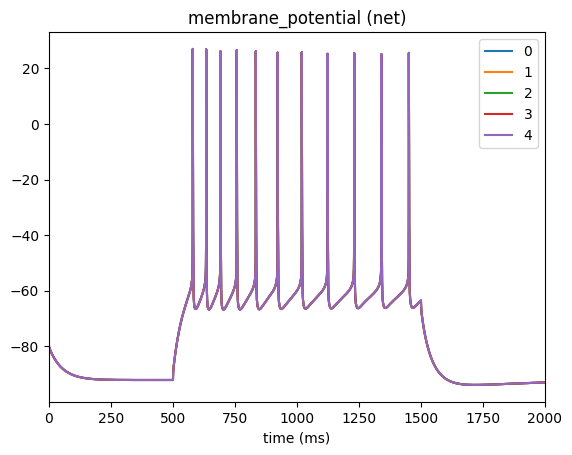

In [11]:
from bmtk.analyzer.compartment import plot_traces
_ = plot_traces(config_file='config.current_clamp.json',  node_ids=range(5), report_name='membrane_potential')

#### Selecting different placement

Besides the `soma`, most morphologically detailed will also give you options to place a clamp at the `axon`, `dend` (aka `basal`, the  basal dendrites), or the `apic` (the apical dendrites). However unlike the `soma`, these other sections may be split into hundreds of different **section_index** (aka branches and compartments). If you do not know the specific section index for where you want to place the clamp you can use specify a range (in microns from the soma) of where to find select the current.

For example if we want to place the current at a random location on the apical or basal dendrites that is atleast 500 um away from the soma

```json
"inputs": {
    "current_clamp_apic": {
    "input_type": "current_clamp",
    "module": "IClamp",
    "node_set": {
        "population": "net", 
        "node_id": [0]
    },
    "amp": 0.1000,
    "delay": 500.0,
    "duration": 1000.0,
    "section_name": ["dend", "apic"],
    "section_index": [500.0, 1.0e20]
    }
}
```
* We are trying to find any section that is (500, $\infty$) away from the soma. However python doesn't handle infinity values very well so we just use a distance, 1e20, that we know will cover all feasible segments

<div class="alert alert-block alert-info">
 WARNING: As metioned before this won't work on point-neurons or neurons with only a soma. Some models may not have an "apic" section and would thus fail.
</div>

In [1]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.current_clamp_apic.json')
conf.build_env()

graph = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=graph)
sim.run()

2024-05-05 11:49:01,014 [INFO] Created log file
2024-05-05 11:49:01,122 [INFO] Building cells.
2024-05-05 11:49:02,108 [INFO] Building recurrent connections
2024-05-05 11:49:02,125 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2024-05-05 11:49:02,127 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-05-05 11:49:02,128 [INFO] Block save every 5000 steps
2024-05-05 11:49:03,210 [INFO]     step:5000 t_sim:500.00 ms
2024-05-05 11:49:04,225 [INFO]     step:10000 t_sim:1000.00 ms
2024-05-05 11:49:05,562 [INFO]     step:15000 t_sim:1500.00 ms
2024-05-05 11:49:06,625 [INFO]     step:20000 t_sim:2000.00 ms
2024-05-05 11:49:06,635 [INFO] Simulation completed in 4.51 seconds 


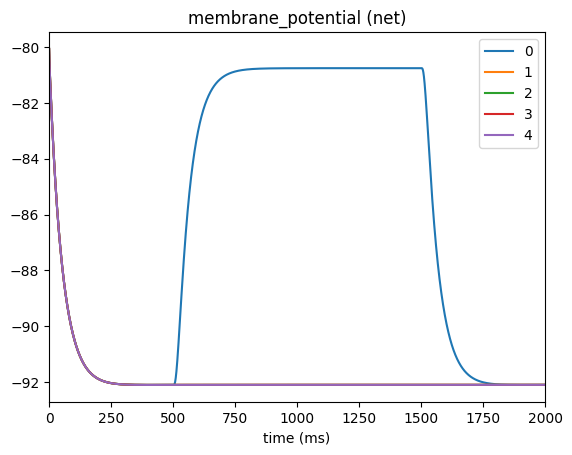

In [2]:
from bmtk.analyzer.compartment import plot_traces
_ = plot_traces(config_file='config.current_clamp_apic.json',  node_ids=range(5), report_name='membrane_potential')

### Adding multiple Clamps

If you need to add multiple current-clamps in sequence or in parallel to you simulation you can easily do it by adding multiple sections to the "inputs" sections:

```json
"inputs": {
    "current_clamp_1": {
        "input_type": "current_clamp",
        "module": "IClamp",
        "node_set": {
            "population": "net", 
            "node_id": [0]
        },
        "amp": 0.1500,
        "delay": 500.0,
        "section_name": "soma"
    },
    "current_clamp_2": {
        "input_type": "current_clamp",
        "module": "IClamp",
        "node_set": {
            "population": "net", 
            "node_id": [0]
        },
        "amp": 0.1750,
        "delay": 1500.0,
        "duration": 500.0,
        "section_name": "soma"
    },
    "current_clamp_3": {
        "input_type": "current_clamp",
        "module": "IClamp",
        "node_set": {
            "population": "net", 
            "node_id": [0]
        },
        "amp": 0.2000,
        "delay": 2500.0,
        "duration": 500.0,
        "section_name": "soma"
    }
}
```

#### As a list

However if you are applying clamps to the same **node_set** and **section** it is also possible to set **amp**, **duration**, and **delay** as a list. The main difference is that we must set the **module** to value `list`.

```json
"inputs": {
    "current_clamp_list": {
        "input_type": "current_clamp",
        "module": "list",
        "node_set": {
            "population": "net", 
            "model_type": "biophysical"
        },
        "amp": [0.1500, 0.1750, 0.2000],
        "delay": [500.0, 1500.0, 2500.0],
        "duration": [500.0, 500.0, 500.0]
        "section_name": "soma"
    }
}
```


## Example: Complex current-clamp forms

In the above example we inserted a current clamp as single or a series of step-currents. However you may want to use another input form like a wave or a gradual current which, if needed to implement in the above, would be very infeasbile. Luckily, BMTK also allows us to save our current function into a csv file which can contain hundreds to thousand of individual points differentiating how the current will change at each step of time.

Implementing this is done in much the same way as in the example above with two exceptions:
1. The **module** should be set to value `csv`.
2. Instead of specifying the **amp**, **delay**, or **duration**; instead you specify the **file** path to the generated csv.

For example to have the sequences of current clamps in the above example we would add the following to our configuration file:

```json
"inputs": {
    "current_clamp_series": {
        "input_type": "csv",
        "module": "IClamp",
        "node_set": {
            "population": "net", 
            "model_type": "biophysical"
        },
        "file": "$INPUT_DIR/iclamp_inputs_series.csv",
        "section_name": "soma"
    }
}
```

Where our file has the following format, each row specifying the time **time-stamp**, where 0 represents beginning of simulation, at at which the **amp** value is changes

In [3]:
import pandas as pd

pd.read_csv('inputs/iclamp_inputs_series.csv', sep=' ')

,timestamps,amps
0,800.0,0.150
1,1300.0,0.000
2,1800.0,0.175
3,2300.0,0.000
4,2800.0,0.200
5,3300.0,0.000


Also note that unlike with the above example there is no **delay**, thus to turn off current between blocks we must reset amp to 0.0

In [5]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.csv_series.json')
conf.build_env()

graph = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=graph)
sim.run()

2024-05-05 12:32:49,833 [INFO] Created log file
Mechanisms already loaded from path: ./components/mechanisms.  Aborting.
2024-05-05 12:32:49,851 [INFO] Building cells.
2024-05-05 12:32:50,585 [INFO] Building recurrent connections
2024-05-05 12:32:50,609 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms
2024-05-05 12:32:50,614 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-05-05 12:32:50,615 [INFO] Block save every 5000 steps
2024-05-05 12:32:52,358 [INFO]     step:5000 t_sim:500.00 ms
2024-05-05 12:32:54,016 [INFO]     step:10000 t_sim:1000.00 ms
2024-05-05 12:32:55,620 [INFO]     step:15000 t_sim:1500.00 ms
2024-05-05 12:32:57,227 [INFO]     step:20000 t_sim:2000.00 ms
2024-05-05 12:32:58,778 [INFO]     step:25000 t_sim:2500.00 ms
2024-05-05 12:33:00,376 [INFO]     step:30000 t_sim:3000.00 ms
2024-05-05 12:33:00,394 [INFO] Simulation completed in 9.785 seconds 


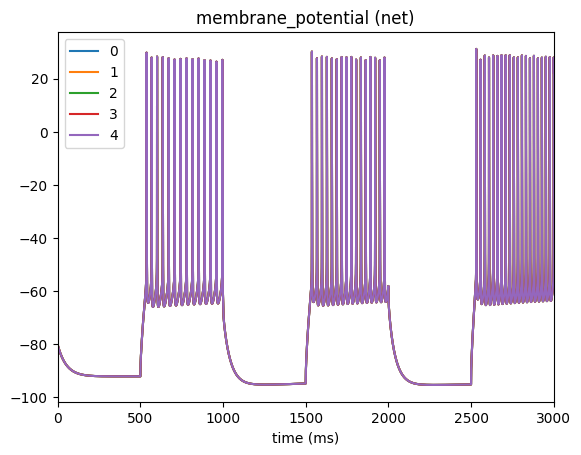

In [6]:
from bmtk.analyzer.compartment import plot_traces
_ = plot_traces(config_file='config.csv_series.json',  node_ids=range(5), report_name='membrane_potential')

For a more complex example, we will use numpy to create current-clamp trace that has a damped wave. We'll save it to file *inputs/iclamp_damped_wave.csv*

In [9]:
import pandas as pd
import numpy as np

start_time = 0.0
stop_time=3000.0
dt=0.1

times_secs = np.arange(start_time, stop_time, step=dt*200)/1000
amps_na = np.sin(times_secs*3*np.pi)*np.exp(-times_secs)
pd.DataFrame({
    'timestamps': np.round(times_secs*1000, decimals=1),
    'amps': amps_na*.1
}).to_csv('inputs/iclamp_damped_wave.csv', sep=' ', index=False)


Then modify the config as such

```json
"inputs": {
    "current_clamp_wave": {
        "input_type": "csv",
        "module": "IClamp",
        "node_set": {
            "population": "net", 
            "model_type": "biophysical"
        },
        "file": "$INPUT_DIR/iclamp_damped_wave.csv",
        "section_name": "soma"
    }
}
```

Then run the simulation and plot the membrane potential to see that indeed, the cell is acting as we would expect when injecting a damped wave into the soma

In [10]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.csv_wave.json')
conf.build_env()

graph = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=graph)
sim.run()

2024-05-05 13:05:33,058 [INFO] Created log file
Mechanisms already loaded from path: ./components/mechanisms.  Aborting.
2024-05-05 13:05:33,072 [INFO] Building cells.
2024-05-05 13:05:34,069 [INFO] Building recurrent connections
2024-05-05 13:05:34,085 [WARNING] IClampMod: Stimulus of ./inputs/iclamp_damped_wave.csv does not end with a 0.0, attempting to set turn off at time 3000.0.
2024-05-05 13:05:34,093 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms
2024-05-05 13:05:34,098 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-05-05 13:05:34,099 [INFO] Block save every 5000 steps
2024-05-05 13:05:35,856 [INFO]     step:5000 t_sim:500.00 ms
2024-05-05 13:05:37,875 [INFO]     step:10000 t_sim:1000.00 ms
2024-05-05 13:05:39,645 [INFO]     step:15000 t_sim:1500.00 ms
2024-05-05 13:05:41,639 [INFO]     step:20000 t_sim:2000.00 ms
2024-05-05 13:05:43,769 [INFO]     step:25000 t_sim:2500.00 ms
2024-05-05 13:05:45,737 [INFO]     step:30000 t_sim:3000.00 ms
2024-05-05 13

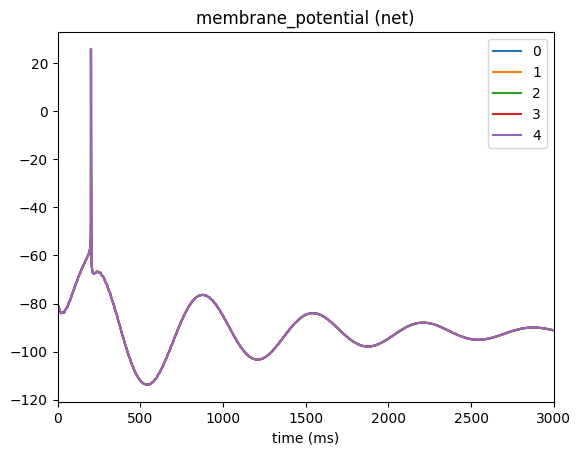

In [11]:
from bmtk.analyzer.compartment import plot_traces
_ = plot_traces(config_file='config.csv_wave.json',  node_ids=range(5), report_name='membrane_potential')

## Example: Voltage Clamps

## Example: Using sweep data from the Allen Cell-Types Database

When creating the [Cell-Type Database at the Allen Insitute](https://celltypes.brain-map.org/data), a wide range of clamping stimuli was used in the process of optimizing the parameters for the thousands of human and mouse cell models. BMTK allows the option to download and import these stimuli directly into single and multi-cell simulations (for both BioNet and PointNet). Thus allowing users to apply the same conditions for their own models. Or as just a way to use much more advanced and realistic current-clamping stimuli that would be difficult to rebuild from scratch.

### Step 1: Downloading the data

First step is determine which experimental conditions we want to replicate and which stimlus types to use. Different cells were in the Allen Cell Types Database were optimized and tested against different types current clamps. For example if we look at the electrophysiology page for [cell 488683425](https://celltypes.brain-map.org/experiment/electrophysiology/488683425) we can see we have stimulus types including `Long square`, `Noise`, `Ramp`, `Short Square` and `Square`. And for each types there are different *sweeps* where amplitudes and times were varied between trials:

<br>
<div>
  <img src="../images/cell_types_screen.png" width="1000" align="center" style="margin-left:5px"/>    
</div>
<br clear="left">

If you click on the "`Download Data`" file it will download an ecephy.nwb file containing all the *sweep* available for said experiment. You just need to put it in a directory that can be accessed by BMTK. If you need a more programatically way to download multiple ecephy files you can use the AllenSDK, and BMTK also includes helper functions to download the data. You can run the following in a command-line:
```bash
$ python -m bmtk.utils.cell_types_db download_ephys_data --specimen-id=488683425 --download-dir=ecephys_inputs
```

Or through the notebook

In [1]:
from bmtk.utils.cell_types_db import download_ephys_data

download_ephys_data(
    specimen_id=488683425,
    download_dir='ephys_inputs'
)

Due to the size of the files and available internet speeds it may take some time to fully donwload the nwb file(s). But when it does it will save the file into the local *ephy_inputs/* directory.

### (Optional) Step 2: Downloading cell model data

The downloaded ephys data can be used with any cell-type (even cells that are not from the Allen Cell-Types Database). However for testing and replication purposes you may want to run the downloaded ephys data on the original cell. If you click on `Select neuronal model` button on the page it will give you an option to download a possible GLIF Model (which can be ran using PointNet) or a Biophysical (ran using BioNet) model. This will download a zip file containing the *fit_parameters.json` which you can use as the **dynamics_params** in you SONATA network. Also for Biophysical models it will contain the file *reconstruction.swc* which is the **morphology** swc file for the specific cell. You can move these file(s) into their appropiate *components/* directory and rebuild/modify the SONATA network file so that **dynamics_params** and **morphology** points to the correct paths.

Alternatively you can use BMTK to download, move and rename the files for you. In the command line you can run:
```bash
$ python -m bmtk.utils.cell_types_db download_model --specimen-id=488683425 --model-dir="components" --model-type="Biophysical - all active"
```

or in python
```python
model_dir = download_model(
    specimen_id=488683425,
    model_dir='components',
    model_type='Biophysical - all active'
)
```


### Step 3: Set the configuration

To use the downloaded ephys.nwb file we just need to create an "inputs sections with **module** set to `iclamp` and **input_type** set to `allen`. Use the **file** option to point to the path of our downloaded nwb file. And finally we must select our **sweep** number. In this case we'll use swepp #35 which is just a 1 second long-square current.

```json
"inputs": {
    "current_clamp_allen": {
        "module": "IClamp",
        "input_type": "allen",
        "node_set": "all",
        "file": "${INPUT_DIR}/488683423_ephys.nwb",
        "sweep_id": "35"
    }
}
```


In [3]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.cell_types.json')
conf.build_env()

graph = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=graph)
sim.run()

2024-05-05 14:54:45,142 [INFO] Created log file
2024-05-05 14:54:45,243 [INFO] Building cells.
2024-05-05 14:54:45,490 [INFO] Building recurrent connections
2024-05-05 14:54:45,857 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms
2024-05-05 14:54:45,858 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-05-05 14:54:45,859 [INFO] Block save every 5000 steps
2024-05-05 14:54:53,078 [INFO]     step:5000 t_sim:500.00 ms
2024-05-05 14:55:00,473 [INFO]     step:10000 t_sim:1000.00 ms
2024-05-05 14:55:07,069 [INFO]     step:15000 t_sim:1500.00 ms
2024-05-05 14:55:13,562 [INFO]     step:20000 t_sim:2000.00 ms
2024-05-05 14:55:20,164 [INFO]     step:25000 t_sim:2500.00 ms
2024-05-05 14:55:26,899 [INFO]     step:30000 t_sim:3000.00 ms
2024-05-05 14:55:26,917 [INFO] Simulation completed in 41.06 seconds 


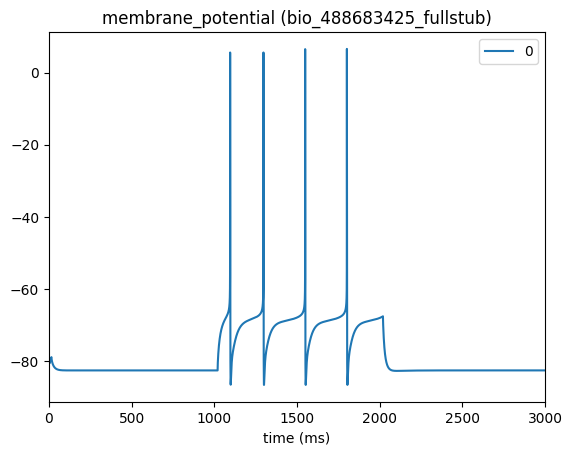

In [4]:
from bmtk.analyzer.compartment import plot_traces
_ = plot_traces(config_file='config.cell_types.json',  node_ids=[0], report_name='membrane_potential')

## Example: Extracellular Stimulation

In [ ]:
## Example: Using 